# Python 信号処理

## Resources

[MATLAB 信号処理入門](https://jp.mathworks.com/learn/tutorials/signal-processing-onramp.html
)

[Interface 2021年3月号　Pythonで信号処理［時系列データ 解析編］【PDF版】](https://cc.cqpub.co.jp/lib/system/doclib_item/1319/)


In [ ]:
# Template Code

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq

In [ ]:

def read_dat(filename):
    """
    波形データファイルの読み込み. (ASCII format)

    Parameters
    ----------
    filename : str
        データファイル名.

    Returns
    -------
    dat : ndarray
        波形データ.

    """
    dat = np.loadtxt(filename, delimiter='\t')
    dat = dat[0:int(Fs * DAT_LEN), CH] * AMP_COEF
    return dat


def plot_wave(dat, is_wide=True):
    """
    波形データの描画.

    Parameters
    ----------
    dat : ndarray
        入力データ.
    is_wide : bool, optional
        True: 波形エリア横長, False: 波形エリア通常. 初期値：True.

    Returns
    -------
    なし.

    """
    t = np.arange(len(dat)) / Fs
    if is_wide:
        plt.figure(figsize=[11, 4])
    else:
        plt.figure(figsize=[7, 4])

    plt.plot(t, dat)
    plt.ylim(-YLIM, YLIM)
    plt.xlabel('Time [s]')
    plt.ylabel('Ch' + str(CH + 1) + ' [uV]')
    plt.show()


def plot_spectrum(dat, window='boxcar', mode='psd'):
    """
    パワー/振幅・スペクトル密度の描画(PSD/ASD).

    Parameters
    ----------
    dat : ndarray
        入力データ.
    window : str, optional
        窓関数の名前. scipy.signal.get_window()参照.
        初期値は'boxcar'.
    mode : str, optional
        'asd'の場合ASD,それ以外の場合PSD. 初期値：'psd'.

    Returns
    -------
    なし.

    """
    LEN = len(dat)
    win = signal.get_window(window, LEN)
    enbw = LEN * np.sum(win**2) / np.sum(win)**2

    # 両側スペクトル (参考（未使用）)
    fft_dat = fftshift(fft(dat * win))
    fft_freq = fftshift(fftfreq(LEN, d=1.0 / Fs))
    sp_dat = np.abs(fft_dat)**2 / (LEN * Fs * enbw)
    sp_dat[1:-1] *= 2  # 2倍（DCとナイキスト周波数除く）

    # 片側スペクトル
    rfft_dat = rfft(dat * win)
    rfft_freq = rfftfreq(LEN, d=1.0 / Fs)
    sp_rdat = np.abs(rfft_dat)**2 / (LEN * Fs * enbw)
    sp_rdat[1:-1] *= 2  # 2倍（DCとナイキスト周波数除く）

    if mode == 'asd':
        sp_dat = np.sqrt(sp_dat)
        sp_rdat = np.sqrt(sp_rdat)

    plt.figure(figsize=[7, 4])
    plt.plot(rfft_freq, sp_rdat)
    plt.xlabel('Frequency [Hz]')
    if mode == 'asd':
        plt.ylabel('ASD [uV/rtHz]')  # ASD (Amplitude spectral density)
    else:
        plt.ylabel('PSD [uV^2/Hz]')  # PSD (Power spectral density)

    plt.show()


def plot_psd(dat):
    """
    ピリオドグラム，ウェルチ法を用いたPSDの描画.

    Parameters
    ----------
    dat : ndarray
        入力データ.

    Returns
    -------
    なし.

    """
    f1, Pxx1 = signal.periodogram(dat, Fs, window='boxcar')
    f2, Pxx2 = signal.welch(dat,
                            Fs,
                            window='boxcar',
                            nperseg=Fs,
                            noverlap=Fs // 2)
    plt.figure(figsize=[7, 4])
    plt.plot(f1, 10 * np.log10(Pxx1), label='periodogram')
    plt.plot(f2, 10 * np.log10(Pxx2), label='welch')
    plt.ylim(-50, 30)
    plt.xlabel('Frequency [s]')
    plt.ylabel('PSD [dB/Hz]')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=[7, 4])
    plt.plot(f1, Pxx1, label='periodogram')
    plt.plot(f2, Pxx2, label='welch')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [uV^2/Hz]')
    plt.legend(loc='best')
    plt.show()


def plot_spectrogram(dat):
    """
    スペクトログラムの描画.

    Parameters
    ----------
    dat : ndarray
        入力データ.

    Returns
    -------
    なし.

    """
    f, t, Sxx = signal.spectrogram(dat,
                                   Fs,
                                   window='boxcar',
                                   nperseg=Fs * 2,
                                   noverlap=Fs,
                                   mode='psd')
    plt.figure(figsize=[13, 4])
    plt.pcolormesh(t, f, Sxx, cmap='jet', vmax=VMAX)
    plt.ylim([0, Fs / 2])
    plt.xlabel('Time [s]')
    plt.ylabel('Freq [Hz]')
    plt.colorbar().set_label('PSD [uV^2/Hz]')
    plt.show()


def plot_all(dat):
    """
    全ての処理を実行.

    Parameters
    ----------
    dat : ndarray
        入力データ.

    Returns
    -------
    なし.

    """
    plot_wave(dat)
    plot_spectrogram(dat)
    # 閉眼時
    close_idx_bgn = int(Fs * EYE_CLOSE)
    close_idx_end = int(Fs * (EYE_CLOSE + SPECRUM_LEN))
    dat_eye_close = dat[close_idx_bgn:close_idx_end]
    dat_eye_close = dat_eye_close - np.mean(dat_eye_close)
    plot_wave(dat_eye_close, False)
    plot_spectrum(dat_eye_close)
    plot_psd(dat_eye_close)
    # 開眼時
    open_idx_bgn = int(Fs * EYE_OPEN)
    open_idx_end = int(Fs * (EYE_OPEN + SPECRUM_LEN))
    dat_eye_open = dat[open_idx_bgn:open_idx_end]
    dat_eye_open = dat_eye_open - np.mean(dat_eye_open)
    plot_wave(dat_eye_open, False)
    plot_spectrum(dat_eye_open)
    plot_psd(dat_eye_open)



In [50]:
# 周波数応答を描画

def plot_freqz(b, a, title=''):
    w, h = signal.freqz(b, a, worN=np.logspace(-2, 2, 512), fs=Fs)

    plt.figure()
    plt.subplot(211)
    plt.semilogx(w, 20 * np.log10(np.abs(h)))
    plt.ylim(-45, 5)
    plt.ylabel('Gain (dB)')
    plt.axvline(cutoff)
    plt.title(title)
    plt.grid(which='both', axis='both')

    plt.subplot(212)
    plt.semilogx(w, np.angle(h))
    plt.ylabel('Phase (Rad)')
    plt.xlabel('Frequency (Hz)')
    plt.grid(which='both', axis='both')
    plt.suptitle('Frequency Response')

    plt.show()





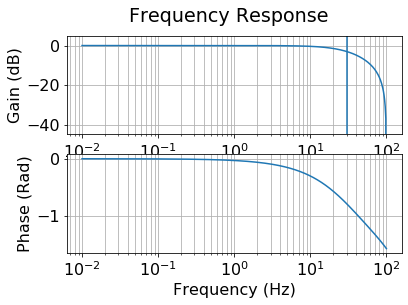

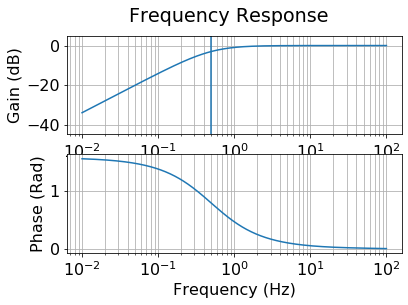

In [52]:

Fs = 200  # サンプリング周波数

Fh = 0.5  # ハイパス・フィルタ遮断周波数
Fl = 30.0  # ローパス・フィルタ遮断周波数
Nf = 1  # ハイパス・フィルタ/ローパス・フィルタの次数

Fn = 50.0  # ノッチ・フィルタの中心周波数
Q = 4.0  # ノッチ・フィルタのQ値

AMP_COEF = 5.0 / 2**12 / 1000 * 1000000  # 5V / 12bitADC / Gain=1000 [uV]

plt.rcParams["font.size"] = 16  # フォントサイズ

YLIM = 310  # 波形のY軸レンジ(+/-)
VMAX = 100  # スペクトログラムのカラーマップスケール

CH = 1  # 対象チャネル (0: Ch1, 1: Ch2)
DAT_LEN = 100  # データ長[s]

EYE_CLOSE = 43  # 閉眼時の開始時刻[s]
EYE_OPEN = 70  # 閉眼時の開始時刻[s]
SPECRUM_LEN = 2  # スペクトルの解析時間[s]

EEG_FILE_NAME = 'Resources/IF2103TS1/eeg.txt'  # 脳波データファイル

# フィルタの設計
bh, ah = signal.butter(Nf, Fh, 'high', fs=Fs)
bl, al = signal.butter(Nf, Fl, 'low', fs=Fs)
bn, an = signal.iirnotch(Fn, Q, fs=Fs)

if __name__ == "__main__":

    # ローパスフィルタの周波数応答
    Fs = 200
    cutoff = 30
    Nf = 1
    b, a = signal.butter(Nf, cutoff, 'low', fs=Fs)
    plot_freqz(b, a)

    # ハイパスフィルタの周波数応答
    Fs = 200
    cutoff = 0.5
    Nf = 1
    b, a = signal.butter(Nf, cutoff, 'high', fs=Fs)
    plot_freqz(b, a)

    # 生波形
    dat = read_dat(EEG_FILE_NAME)
    # plot_all(dat)

    # バンドパス・フィルタを適用
    # dat = signal.lfilter(bh, ah, dat)
    # dat = signal.lfilter(bl, al, dat)
    # plot_all(dat)

    # ノッチ・フィルタを適用
    # dat = signal.lfilter(bn, an, dat)
    # plot_all(dat)
